<a href="https://colab.research.google.com/github/dksifoua/Neural-Machine-Translation/blob/master/4%20-%20SeqToSeq%20Model%20with%20Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Sep 30 00:08:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [2]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download de >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [3]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load data

In [167]:
%%time
DE = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='de', batch_first=True)
EN = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='en', include_lengths=True, batch_first=True)
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN))
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
CPU times: user 6.43 s, sys: 113 ms, total: 6.54 s
Wall time: 6.54 s


## Build vocabularies

In [168]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data, min_freq=MIN_COUNT)
EN.build_vocab(train_data, min_freq=MIN_COUNT)
print(f'Length of DE vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of DE vocabulary: 7,854
Length of EN vocabulary: 5,893
CPU times: user 283 ms, sys: 1.78 ms, total: 285 ms
Wall time: 285 ms


## Modeling

The `scale` variable is used by the authors to *ensure that the variance throughout the network does not change dramatically*. The performance of the model seems to vary wildly using different seeds if this is not used.

***Encoder layer***

In [169]:
class ConvBlockEncodeLayer(nn.Module):

    def __init__(self, n_channels, kernel_size, scale, dropout):
        super(ConvBlockEncodeLayer, self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.scale = scale
        self.dropout = dropout
        self.conv1d = nn.Conv1d(n_channels, n_channels * 2, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)

    def forward(self, conv_input):
        """
        :param Tensor[batch_size, n_channels, src_seq_len] conv_input
        :return [batch_size, n_channels, src_seq_len]
        """
        conved = self.conv1d(conv_input) # [batch_size, n_channels * 2, src_seq_len]
        conved = F.dropout(F.glu(conved, dim=1), p=self.dropout) # [batch_size, n_channels, src_seq_len]
        conved = conv_input + conved # [batch_size, n_channels, src_seq_len] Residual connection
        return conved * self.scale

In [170]:
class EncoderLayer(nn.Module):

    def __init__(self, vocab_size, n_positions, embedding_size, hidden_size, kernel_size, scale, n_layers, dropout):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.scale = scale
        self.n_layers = n_layers
        self.dropout = dropout
        self.token_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(n_positions, embedding_size)
        self.fc_embedding_hidden = nn.Linear(embedding_size, hidden_size)
        self.conv1d_blocks = nn.Sequential(*[ConvBlockEncodeLayer(n_channels=hidden_size, kernel_size=kernel_size, scale=scale,
                                                                  dropout=dropout) for _ in range(n_layers)])
        self.fc_hidden_embedding = nn.Linear(hidden_size, embedding_size)

    def forward(self, input_sequences, input_positions):
        """
        :param Tensor[batch_size, src_seq_len] input_sequences
        :param Tensor[batch_size, src_seq_len] input_positions
        :return Tensor[batch_size, src_seq_len, embedding_size] conved
        :return Tensor[batch_size, src_seq_len, embedding_size] combined
        """
        seq_embed = self.token_embedding(input_sequences) # [batch_size, src_seq_len, embedding_size]
        pos_embed = self.position_embedding(input_positions) # [batch_size, src_seq_len, embedding_size]
        embed = F.dropout(seq_embed + pos_embed, p=self.dropout) # [batch_size, src_seq_len, embedding_size]
        conv_input = F.dropout(self.fc_embedding_hidden(embed), p=self.dropout) # [batch_size, src_seq_len, hidden_size]
        conv_input = conv_input.permute(0, 2, 1) # [batch_size, hidden_size, src_seq_len]
        conved = self.conv1d_blocks(conv_input) # [batch_size, hidden_size, src_seq_len]
        conved = conved.permute(0, 2, 1) # [batch_size, src_seq_len, hidden_size]
        conved = self.fc_hidden_embedding(conved) # [batch_size, src_seq_len, embedding_size]
        combined = (conved + embed) * self.scale # [batch_size, src_seq_len, embedding_size]
        return conved, combined

***Attention layer***

In [171]:
class MultiStepAttnLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size, scale):
        super(MultiStepAttnLayer, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.scale = scale
        self.fc_hidden_embedding = nn.Linear(hidden_size, embedding_size)
    
    def forward(self, embed, conved, enc_conved):
        """
        :param Tensor[batch_size, dest_seq_len, embedding_size] embed
        :param Tensor[batch_size, dest_seq_len, hidden_size] conved
        :param Tensor[batch_size, src_seq_len, embedding_size] enc_conved
        :return Tensor[batch_size, dest_seq_len, src_seq_len] attn_weights
        """
        conv_embed = self.fc_hidden_embedding(conved) # [batch_size, dest_seq_len, embedding_size]
        combined = (conv_embed + embed) * self.scale # [batch_size, dest_seq_len, embedding_size]
        scores = torch.matmul(combined, enc_conved.permute(0, 2, 1)) # [batch_size, dest_seq_len, src_seq_len]
        attn_weights = F.softmax(scores, dim=2) # [batch_size, dest_seq_len, src_seq_len]
        return attn_weights

***Decoder layer***

In [172]:
class ConvBlockDecodeLayer(nn.Module):

    def __init__(self, n_channels, kernel_size, scale, dropout, pad_index):
        super(ConvBlockDecodeLayer, self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.scale = scale
        self.dropout = dropout
        self.pad_index = pad_index
        self.conv1d = nn.Conv1d(n_channels, n_channels * 2, kernel_size=kernel_size)

    def forward(self, conv_input):
        """
        :param Tensor[batch_size, n_channels, dest_seq_len] conv_input
        :return [batch_size, n_channels, dest_seq_len] conved
        """
        padding = torch.zeros(conv_input.size(0), self.n_channels, self.kernel_size - 1).fill_(self.pad_index).to(conv_input.device)
        conv_input_padded = torch.cat((padding, conv_input), dim=2) # [batch_size, n_channels, dest_seq_len + kernel_size - 1] Padding
        conved = self.conv1d(conv_input_padded) # [batch_size, n_channels * 2, dest_seq_len]
        conved = F.dropout(F.glu(conved, dim=1), p=self.dropout) # [batch_size, n_channels, dest_seq_len]
        return conved

In [173]:
class DecoderLayer(nn.Module):

    def __init__(self, vocab_size, n_positions, embedding_size, hidden_size, kernel_size, scale, n_layers, attention_layer, dropout, pad_index):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.scale = scale
        self.n_layers = n_layers
        self.attention_layer = attention_layer
        self.dropout = dropout
        self.pad_index = pad_index
        self.token_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(n_positions, embedding_size)
        self.fc_embedding_hidden = nn.Linear(embedding_size, hidden_size)
        self.fc_embedding_hidden_attn = nn.Linear(embedding_size, hidden_size)
        self.conv1d_blocks = nn.ModuleList([ConvBlockDecodeLayer(n_channels=hidden_size, kernel_size=kernel_size, scale=scale,
                                                                 dropout=dropout, pad_index=pad_index) for _ in range(n_layers)])
        self.fc_hidden_embedding = nn.Linear(hidden_size, embedding_size)
        self.fc = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, input_sequences, input_positions, enc_conved, enc_combined):
        """
        :param Tensor[batch_size, dest_seq_len] input_sequences
        :param Tensor[batch_size, dest_seq_len] input_positions
        :param Tensor[batch_size, src_seq_len, embedding_size] enc_conved
        :param Tensor[batch_size, src_seq_len, embedding_size] enc_combined
        :return Tensor[batch_size, dest_seq_len, vocab_size] logits
        :return [batch_size, dest_seq_len, src_seq_len] attn_weights
        """
        seq_embed = self.token_embedding(input_sequences) # [batch_size, dest_seq_len, embedding_size]
        pos_embed = self.position_embedding(input_positions) # [batch_size, dest_seq_len, embedding_size]
        embed = F.dropout(seq_embed + pos_embed, p=self.dropout) # [batch_size, dest_seq_len, embedding_size]
        conv_input = F.dropout(self.fc_embedding_hidden(embed), p=self.dropout) # [batch_size, dest_seq_len, hidden_size]
        conv_input = conv_input.permute(0, 2, 1) # [batch_size, hidden_size, dest_seq_len]
        for conv1d_block in self.conv1d_blocks:
            conved = conv1d_block(conv_input) # [batch_size, hidden_size, dest_seq_len]
            attn_weights = self.attention_layer(embed=embed, conved=conved.permute(0, 2, 1), enc_conved=enc_conved) # [batch_size, dest_seq_len, src_seq_len]
            attended_encoding = torch.matmul(attn_weights, enc_combined) # [batch_size, dest_seq_len, embedding_size]
            attended_encoding = self.fc_embedding_hidden_attn(attended_encoding) # [batch_size, dest_seq_len, hidden_size]
            attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale # [batch_size, hidden_size, dest_seq_len] Residual connection
            conv_input = (conv_input + attended_combined) * self.scale # [batch_size, hidden_size, dest_seq_len] Residual connection
        conved = conv_input.permute(0, 2, 1) # [batch_size, dest_seq_len, hidden_size]
        conved = self.fc_hidden_embedding(conved) # [batch_size, dest_seq_len, embedding_size]
        logits = self.fc(F.dropout(conved, p=self.dropout)) # [batch_size, dest_seq_len, vocab_size]
        return logits, attn_weights

***Sequence-to-sequence model***

In [174]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'
        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_seq_len] src_sequences
        :param Tensor[batch_size, dest_seq_len] dest_sequences
        :return Tensor[batch_size, dest_seq_len, vocab_size] logits
        :return [batch_size, dest_seq_len, src_seq_len] attn_weights
        """
        src_seq_len, dest_seq_len, batch_size = src_sequences.size(1), dest_sequences.size(1), dest_sequences.size(0)
        src_positions = torch.arange(0, src_seq_len).unsqueeze(0).repeat(batch_size, 1).to(src_sequences.device) # [batch_size, src_seq_len]
        dest_positions = torch.arange(0, dest_seq_len).unsqueeze(0).repeat(batch_size, 1).to(dest_sequences.device) # [batch_size, dest_seq_len]
        enc_conved, enc_combined = self.encoder(input_sequences=src_sequences, input_positions=src_positions) # Encoding
        logits, attn_weights = self.decoder(input_sequences=dest_sequences, input_positions=dest_positions, enc_conved=enc_conved, enc_combined=enc_combined) # Decoding
        return logits, attn_weights

***Training routines***

In [248]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [249]:
def accuracy(outputs, target_sequences, k=5):
    """
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [251]:
class Trainer:

    def __init__(self, model, optimizer, criterion, train_iterator, valid_iterator):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

    def clip_gradients(self, grad_clip):
        if grad_clip is not None:
            for group in self.optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

    def adjust_lr(self, shrink_factor=0.9, verbose=True):
        if verbose:
            print("\nDecaying learning rate.")
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * shrink_factor
        if verbose:
            print("The new learning rate is %f\n" % (self.optimizer.param_groups[0]['lr'],))
    
    def train_step(self, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(self.train_iterator), total=len(self.train_iterator))
        for i, data in progress_bar:
            src_sequences, dest_sequences, dest_lengths = data.src, *data.trg
            decode_lengths = (dest_lengths - 1).tolist()
            logits, _ = self.model(src_sequences, dest_sequences[:, :-1]) # [batch_size, dest_seq_len, vocab_size]
            loss = criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), dest_sequences[:, :-1].contiguous().view(-1))
            optimizer.zero_grad()
            loss.backward()
            self.clip_gradients(grad_clip)
            optimizer.step()
            loss_tracker.update(loss.item(), sum(decode_lengths))
            acc_tracker.update(accuracy(logits, dest_sequences[:, :-1]), sum(decode_lengths))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(self.valid_iterator), total=len(self.valid_iterator))
            for i, data in progress_bar:
                src_sequences, dest_sequences, dest_lengths = data.src, *data.trg
                decode_lengths = (dest_lengths - 1).tolist()
                logits, _ = self.model(src_sequences, dest_sequences[:, :-1]) # [batch_size, dest_seq_len, vocab_size]
                loss = criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), dest_sequences[:, :-1].contiguous().view(-1))
                loss_tracker.update(loss.item(), sum(decode_lengths))
                acc_tracker.update(accuracy(logits, dest_sequences[:, :-1]), sum(decode_lengths))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, n_epochs, grad_clip):
        history = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}
        best_loss, last_improv = np.inf, 0
        for epoch in range(n_epochs):
            if last_improv == 4:
                print('Training Finished - The model has stopped improving since last 4 epochs')
                break
            if last_improv > 0:
                self.adjust_lr()
            loss, ppl, acc = self.train_step(epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(epoch)
            
            if best_loss > val_loss:
                best_loss, last_improv = val_loss, 0
                torch.save(self.model.state_dict(), 'seq2seq-luong-attn.pth')
            else:
                last_improv += 1
                print(f'\nLast improvement since epoch {epoch - last_improv + 1}')
            
            history['acc'].append(acc)
            history['ppl'].append(ppl)
            history['loss'].append(loss)
            history['val_acc'].append(val_acc)
            history['val_ppl'].append(val_ppl)
            history['val_loss'].append(val_loss)
        return history

***Train the model***

In [252]:
N_LAYERS = 2
HIDDEN_SIZE = 256
EMBED_SIZE = 300
KERNEL_SIZE = 3
DROPOUT = 0.25
SCALE = np.sqrt(0.5)
N_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [253]:
encoder_layer = EncoderLayer(vocab_size=len(DE.vocab), n_positions=50, embedding_size=EMBED_SIZE,
                             hidden_size=HIDDEN_SIZE, kernel_size=KERNEL_SIZE, scale=SCALE,
                             n_layers=N_LAYERS, dropout=DROPOUT)
attention_layer = MultiStepAttnLayer(hidden_size=HIDDEN_SIZE, embedding_size=EMBED_SIZE, scale=SCALE)
decoder_layer = DecoderLayer(vocab_size=len(EN.vocab), n_positions=50, embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                             kernel_size=KERNEL_SIZE, scale=SCALE, n_layers=N_LAYERS, attention_layer=attention_layer,
                             dropout=DROPOUT, pad_index=EN.vocab.stoi[EN.pad_token])
seq2seq = SeqToSeqNet(encoder=encoder_layer, decoder=decoder_layer).to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in seq2seq.parameters() if p.requires_grad):,}')
print(seq2seq)
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train_data, valid_data, test_data),
                                                                       batch_size=BATCH_SIZE,
                                                                       sort_key=lambda x: len(x.trg),
                                                                       sort_within_batch=True, device=DEVICE)
trainer = Trainer(model=seq2seq, optimizer=optimizer, criterion=criterion, train_iterator=train_iterator, valid_iterator=valid_iterator)

Number of parameters of the model: 7,965,273
SeqToSeqNet(
  (encoder): EncoderLayer(
    (token_embedding): Embedding(7854, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (conv1d_blocks): Sequential(
      (0): ConvBlockEncodeLayer(
        (conv1d): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ConvBlockEncodeLayer(
        (conv1d): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
  )
  (decoder): DecoderLayer(
    (attention_layer): MultiStepAttnLayer(
      (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    )
    (token_embedding): Embedding(5893, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_embedding_hidden_attn): Linear(in_features=300

In [254]:
history = trainer.train(n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 1.436 -     ppl: 4.206 -     acc: 16.984%: 100%|██████████| 454/454 [00:08<00:00, 53.54it/s]
Epoch: 01 - val_loss: 0.347 - val_ppl: 1.414 - val_acc: 18.874%: 100%|██████████| 16/16 [00:00<00:00, 109.05it/s]
Epoch: 02 -     loss: 0.288 -     ppl: 1.333 -     acc: 19.315%: 100%|██████████| 454/454 [00:08<00:00, 53.78it/s]
Epoch: 02 - val_loss: 0.147 - val_ppl: 1.159 - val_acc: 19.275%: 100%|██████████| 16/16 [00:00<00:00, 114.35it/s]
Epoch: 03 -     loss: 0.148 -     ppl: 1.159 -     acc: 19.592%: 100%|██████████| 454/454 [00:08<00:00, 53.51it/s]
Epoch: 03 - val_loss: 0.092 - val_ppl: 1.097 - val_acc: 19.398%: 100%|██████████| 16/16 [00:00<00:00, 118.50it/s]
Epoch: 04 -     loss: 0.132 -     ppl: 1.141 -     acc: 19.676%: 100%|██████████| 454/454 [00:08<00:00, 53.96it/s]
Epoch: 04 - val_loss: 0.082 - val_ppl: 1.085 - val_acc: 19.422%: 100%|██████████| 16/16 [00:00<00:00, 120.92it/s]
Epoch: 05 -     loss: 0.081 -     ppl: 1.084 -     acc: 19.752%: 100%|██████████| 45


Last improvement since epoch 8

Decaying learning rate.
The new learning rate is 0.000900



Epoch: 10 -     loss: 0.062 -     ppl: 1.064 -     acc: 19.821%: 100%|██████████| 454/454 [00:08<00:00, 52.91it/s]
Epoch: 10 - val_loss: 0.050 - val_ppl: 1.051 - val_acc: 19.482%: 100%|██████████| 16/16 [00:00<00:00, 117.08it/s]


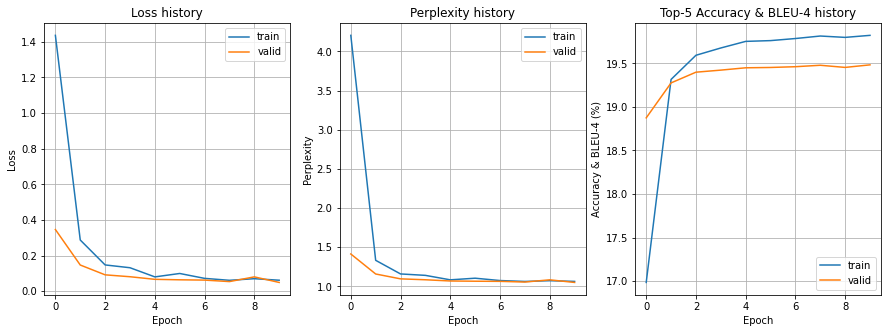

In [255]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

## Evaluation - Beam search & BLEU score

In [269]:
from beam_utils import Node, find_best_path, find_path

def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, (dest_sequence, dest_length)) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, dest_sequence, dest_length = src_sequence.to(device), dest_sequence.to(device), dest_length.to(device)
            
            src_seq_len = src_sequence.size(1)
            src_position = torch.arange(0, src_seq_len).unsqueeze(0).repeat(1, 1).to(device) # [1, src_seq_len]
            
            # Encoding
            enc_conved, enc_combined = model.encoder(input_sequences=src_sequence, input_positions=src_position)
            
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=None)]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_best_path(tree))][::-1]).unsqueeze(0).to(device)
                    already_position = torch.arange(0, already_translated.size(1)).unsqueeze(0).repeat(1, 1).to(device)
                    print(already_translated.shape)
                    print([*map(lambda node: dest_field.vocab.itos[node.token], find_best_path(tree))][::-1])
                    print([*map(lambda token: dest_field.vocab.itos[token], dest_sequence[0])])
                    print('='*100)

                    # Decoding
                    logit, _ = model.decoder(input_sequences=already_translated, input_positions=already_position,
                                             enc_conved=enc_conved, enc_combined=enc_combined) # [1, dest_seq_len, vocab_size]
                    
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores
                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps
                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=None,
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
                
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence[0] if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence[0] if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [270]:
seq2seq.load_state_dict(torch.load('seq2seq-luong-attn.pth'))
seq2seq.to(DEVICE)

SeqToSeqNet(
  (encoder): EncoderLayer(
    (token_embedding): Embedding(7854, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (conv1d_blocks): Sequential(
      (0): ConvBlockEncodeLayer(
        (conv1d): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ConvBlockEncodeLayer(
        (conv1d): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
  )
  (decoder): DecoderLayer(
    (attention_layer): MultiStepAttnLayer(
      (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    )
    (token_embedding): Embedding(5893, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_embedding_hidden_attn): Linear(in_features=300, out_features=256, bias=True)
    (conv1d_bl

In [271]:
bleu_scores = []
for beam_size in [1, 3, 5]:
    for name, data in [('validation', valid_data), ('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=seq2seq, data=data, beam_size=beam_size, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        print(bleu4)
        
for score in bleu_scores:
    print(f'BLEU-4: {score[2]*100:.3f}% with beam_size={score[0]} on {score[1]} data')

  0%|          | 1/1014 [00:00<03:31,  4.79it/s]

torch.Size([1, 1])
['<sos>']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 2])
['<sos>', '<sos>']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 3])
['<sos>', '<sos>', 'professionally']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 4])
['<sos>', '<sos>', 'professionally', 'professionally']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 5])
['<sos>', '<sos>', 'professionally', 'professionally', 'professionally']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 6])
['<sos>', '<sos>', 'professionally', 'professionally', 'professionally', 'professionally']
['<sos>', 'a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', '<eos>']
torch.Size([1, 7])
['<sos

  0%|          | 2/1014 [00:00<03:30,  4.82it/s]

torch.Size([1, 1])
['<sos>']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 2])
['<sos>', '<sos>']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 3])
['<sos>', '<sos>', 'elder']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 4])
['<sos>', '<sos>', 'elder', 'elder']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 5])
['<sos>', '<sos>', 'elder', 'elder', 'elder']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 6])
['<sos>', '<sos>', 'elder', 'elder', 'elder', 'elder']
['<sos>', 'a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.', '<eos>']
torch.Size([1, 7])
['<sos>', '<sos>', 'elder', 'elder', 'elder', 'elder', 'elder']
['<sos>', 'a', 'man', 'sleeping'

  0%|          | 3/1014 [00:00<03:35,  4.69it/s]

['<sos>', 'a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.', '<eos>']
torch.Size([1, 50])
['<sos>', '<sos>', 'snowmobile', 'snowmobile', 'treeless', 'treeless', 'treeless', 'treeless', 'treeless', 'treeless', 'treeless', 'treeless', 'grips', 'awning', 'awning', 'awning', 'awning', 'carnival', 'carnival', 'carnival', 'carnival', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'legs', 'dog', 'dog', 'dog', 'dog', 'dog', 'r', 'r', 'intimate', 'chair', 'chair', 'chair']
['<sos>', 'a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.', '<eos>']
torch.Size([1, 1])
['<sos>']
['<sos>', 'two', 'men', 'setting', 'up', 'a', 'blue', 'ice', 'fishing', 'hut', 'on', 'an', 'iced', 'over', 'lake', '<eos>']
torch.Size([1, 2])
['<sos>', '<sos>']
['<sos>', 'two', 'men', 'setting', 'up', 'a', 'blue', 'ice', 'fishing', 'hut', 'on', 'an', 'iced', 'over'

  0%|          | 4/1014 [00:00<03:33,  4.73it/s]

torch.Size([1, 50])
['<sos>', '<sos>', 'regal', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'conversing', 'intimate', 'park', 'its', 'its', 'its', 'its', 'different', 'different', 'different', 'performing', 'performing', 'performing']
['<sos>', 'two', 'men', 'setting', 'up', 'a', 'blue', 'ice', 'fishing', 'hut', 'on', 'an', 'iced', 'over', 'lake', '<eos>']
torch.Size([1, 1])
['<sos>']
['<sos>', 'a', 'balding', 'man', 'wearing', 'a', 'red', 'life', 'jacket', 'is', 'sitting', 'in', 'a', 'small', 'boat', '.', '<eos>']
torch.Size([1, 2])
['<sos>', '<sos>']
['<sos>',

  0%|          | 5/1014 [00:01<03:37,  4.64it/s]

['<sos>', '<sos>', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'crowd', 'crowd', 'crowd', 'painted', 'painted']
['<sos>', 'a', 'balding', 'man', 'wearing', 'a', 'red', 'life', 'jacket', 'is', 'sitting', 'in', 'a', 'small', 'boat', '.', '<eos>']
torch.Size([1, 49])
['<sos>', '<sos>', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'reporter', 'night', 'night', 'night', 'nig

  1%|          | 6/1014 [00:01<03:37,  4.64it/s]

['<sos>', '<sos>', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'simultaneously', 'simultaneously', 'simultaneously', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'because', 'because', 'because', 'pet', 'pet', 'vest', 'vest', 'vest', 'vest', 'vest', 'crossed', 'crossed', 'crossed', 'crossed', 'polish', 'polish', 'photo', 'photo', 'hold']
['<sos>', 'a', 'lady', 'in', 'a', 'red', 'coat', ',', 'holding', 'a', '<unk>', 'hand', 'bag', 'likely', 'of', 'asian', 'descent', ',', 'jumping', 'off', 'the', 'ground', 'for', 'a', '<unk>', '.', '<eos>']
torch.Size([1, 48])
['<sos>', '<sos>', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'elder', 'simultaneously', 'simultaneously', 'simultaneously', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'log', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'bowtie', 'because', 'because', 'because', 'pet', 'pet', 'vest', 'vest',

  1%|          | 7/1014 [00:01<03:38,  4.62it/s]

['<sos>', '<sos>', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'saddled', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed']
['<sos>', 'a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']
torch.Size([1, 47])
['<sos>', '<sos>', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'baby', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'bending', 'saddled', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dressed', 'dress

KeyboardInterrupt: ignored